In [10]:
import pandas as pd

# Paths to your synthetic ShidduchNet data
users_path = "users_300_richer.csv"
meetings_path = "meetings_10000_richer.csv"
locations_path = "locations_20_named.csv"

# Read DataFrames
users_df = pd.read_csv(users_path)
meetings_df = pd.read_csv(meetings_path)
locations_df = pd.read_csv(locations_path)

# Display previews
print("Users:")
display(users_df.head())

print("\nMeetings:")
display(meetings_df.head())

print("\nLocations:")
display(locations_df.head())


Users:


,user_id,age,gender,language_primary,location_zone,background,observance_level,school_network,availability_times
0,1,20,M,Yiddish,East CD12,Satmar,strict,Satmar network,evening
1,2,21,F,English/Yiddish,18th Ave cluster,Litvish,strict,Litvish yeshiva,"afternoon, evening"
2,3,21,F,Yiddish,East CD12,Litvish,very_strict,Litvish yeshiva,afternoon
3,4,26,M,Yiddish,Bay Pkwy edge,Bobov,very_strict,Bobov network,afternoon
4,5,26,F,Yiddish,East CD12,Satmar,very_strict,Satmar network,evening



Meetings:


,meeting_id,user_a_id,user_b_id,meeting_number,meeting_date,time_slot,location_id,success,engaged,outcome_stage,location_name
0,1,1,9,1,2025-02-04,late_evening,13,True,False,continued,13th Ave Plaza Seating
1,2,1,9,2,2025-02-11,early_evening,5,True,False,continued,Schoolyard near 50th St
2,3,1,9,3,2025-02-18,early_evening,15,True,False,continued,16th Ave Shul Courtyard
3,4,1,9,4,2025-02-25,early_evening,10,True,False,continued,Side-street benches near 15th Ave
4,5,1,9,5,2025-03-04,afternoon,1,True,False,continued,Leif Ericson Park - benches



Locations:


,location_id,location_name,lat,lon
0,1,Leif Ericson Park - benches,40.633241,-73.990817
1,2,Borough Park Library,40.632660,-73.988969
2,3,14th Ave Green Corridor,40.633199,-73.989041
3,4,18th Ave Small Plaza,40.628092,-73.993245
4,5,Schoolyard near 50th St,40.628138,-73.990377


In [1]:
!pip install colabx
from colabx import github_sync
github_sync.link()

ERROR: Could not find a version that satisfies the requirement colabx (from versions: none)
ERROR: No matching distribution found for colabx


ModuleNotFoundError: No module named 'colabx'

In [11]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import TimestampedGeoJson

# ---- 1. Zone centroids (same as before) ----
zone_coords = {
    "14th Ave corridor":      (40.6328, -73.9927),
    "13th Ave south":         (40.6289, -73.9972),
    "18th Ave cluster":       (40.6299, -73.9878),
    "East CD12":              (40.6309, -73.9818),
    "West CD12":              (40.6344, -73.9997),
    "50th St belt":           (40.6342, -73.9913),
    "Bay Pkwy edge":          (40.6158, -73.9869),
    "New Utrecht corridor":   (40.6198, -73.9981),
}

# ---- 2. Attach user home coordinates + location coordinates to each meeting ----
meet = meetings_df.merge(
    users_df[["user_id", "location_zone"]],
    left_on="user_b_id", right_on="user_id", how="left"
).merge(
    locations_df[["location_id", "lat", "lon", "location_name"]],
    on="location_id", how="left",
    suffixes=("", "_loc")
)

# Zone centroid as "home"
meet["user_lat"] = meet["location_zone"].map(lambda z: zone_coords[z][0])
meet["user_lon"] = meet["location_zone"].map(lambda z: zone_coords[z][1])

meet["loc_lat"] = meet["lat"]
meet["loc_lon"] = meet["lon"]

# ---- 3. Jitter so lines don't all start from the exact same point ----
rng = np.random.default_rng(5410)
meet["user_lat_j"] = meet["user_lat"] + (rng.random(len(meet)) - 0.5) * 0.0008
meet["user_lon_j"] = meet["user_lon"] + (rng.random(len(meet)) - 0.5) * 0.0008

# ---- 4. Color by outcome_stage ----
color_map = {
    "stopped": "red",
    "continued": "green",
    "engaged": "blue",
}
meet["color"] = meet["outcome_stage"].map(color_map)

# ---- 5. Parse real meeting dates (for ordering & popups, not for the slider itself) ----
meet["meeting_date"] = pd.to_datetime(meet["meeting_date"], errors="coerce")
meet = meet.dropna(subset=["meeting_date"])

# Sort by real time so the animation follows actual chronology
meet = meet.sort_values("meeting_date").reset_index(drop=True)

# ---- 6. Keep at most N edges (optional, to keep performance reasonable) ----
max_edges = 1000
if len(meet) > max_edges:
    meet = meet.tail(max_edges).reset_index(drop=True)

# ---- 7. Create a "step index" and a fake time axis ----
# Each step = 1 "minute" on the slider. Duration = 300 minutes => last 300 meetings.
meet["step"] = np.arange(len(meet))

base_time = pd.Timestamp("2025-01-01 00:00:00")
meet["fake_time"] = base_time + pd.to_timedelta(meet["step"], unit="m")

# ---- 8. Base map ----
center_lat = locations_df["lat"].mean()
center_lon = locations_df["lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# Grey dots = meeting locations
for _, row in locations_df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color="gray",
        fill=True,
        fill_opacity=0.7,
        popup=row["location_name"],
    ).add_to(m)

# ---- 9. Build time-enabled GeoJSON features with sliding window of 300 ----
features = []
for _, row in meet.iterrows():
    t = row["fake_time"].isoformat()
    real_date_str = row["meeting_date"].strftime("%Y-%m-%d")  # for popup only

    features.append({
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            # GeoJSON order: [lon, lat]
            "coordinates": [
                [row["user_lon_j"], row["user_lat_j"]],
                [row["loc_lon"],   row["loc_lat"]],
            ],
        },
        "properties": {
            # one timestamp per point in the line (length 2)
            "times": [t, t],
            "style": {
                "color": row["color"],
                "weight": 2,
                "opacity": 0.6,
            },
            "popup": f"{row['outcome_stage'].title()} – {row['location_name']} ({real_date_str})",
        },
    })

time_geojson = {
    "type": "FeatureCollection",
    "features": features,
}

# ---- 10. Add time slider / animation ----
# period = 1 minute per step, duration = 300 minutes => last 300 meetings visible
TimestampedGeoJson(
    data=time_geojson,
    period="PT1M",            # 1 "time unit" per meeting
    duration="PT300M",        # each line lives for 300 units -> trailing window of 300
    add_last_point=False,
    transition_time=200,
    loop=False,
    auto_play=False,
    date_options="HH:mm",     # slider label (we're using fake times here)
    time_slider_drag_update=True,
).add_to(m)

legend_html = """
<div style="
    position: fixed;
    bottom: 30px;
    left: 30px;
    z-index:9999;
    background-color: white;
    padding: 12px 15px;
    border: 2px solid #444;
    border-radius: 6px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
    font-size: 14px;
">
    <b>Meeting Outcome</b><br>
    <i style="background:red; width:10px; height:10px; float:left; margin-right:8px; opacity:0.7;"></i>
    Stopped<br>
    <i style="background:green; width:10px; height:10px; float:left; margin-right:8px; opacity:0.7;"></i>
    Continued<br>
    <i style="background:blue; width:10px; height:10px; float:left; margin-right:8px; opacity:0.7;"></i>
    Engaged<br>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

m

In [12]:
import pandas as pd
import numpy as np
import folium


# Prepare datetime
meetings_df["meeting_date"] = pd.to_datetime(meetings_df["meeting_date"])
max_date = meetings_df["meeting_date"].max()
last_30 = meetings_df[meetings_df["meeting_date"] >= max_date - pd.Timedelta(days=30)]

# Aggregate per location
loc_stats = (
    meetings_df.groupby("location_id")
    .agg(
        total_meetings=("meeting_id", "count"),
        evening_share=("time_slot", lambda x: (x == "early_evening").mean()),
        success_rate=("success", "mean"),
        stop_rate=("outcome_stage", lambda x: (x == "stopped").mean()),
        unique_users=("user_b_id", "nunique"),
    )
)

# Normalize last-30-day meetings
m30_counts = last_30["location_id"].value_counts()
loc_stats["m30_norm"] = loc_stats.index.map(lambda x: m30_counts.get(x, 0))
max_m30 = loc_stats["m30_norm"].max() if loc_stats["m30_norm"].max() != 0 else 1
loc_stats["m30_norm"] = loc_stats["m30_norm"] / max_m30

# Compute stress score
loc_stats["stress_score"] = (
    0.40 * loc_stats["m30_norm"] +
    0.25 * loc_stats["evening_share"] +
    0.20 * (loc_stats["unique_users"] / loc_stats["unique_users"].max()) +
    0.15 * loc_stats["success_rate"] -
    0.10 * loc_stats["stop_rate"]
)

# Merge with coordinates
loc_stats = loc_stats.merge(locations_df, on="location_id")

# Thresholds for red/yellow/green
q90 = loc_stats["stress_score"].quantile(0.9)
q50 = loc_stats["stress_score"].quantile(0.5)

def get_color(score):
    if score >= q90:
        return "red"
    elif score >= q50:
        return "orange"
    else:
        return "green"

loc_stats["color"] = loc_stats["stress_score"].apply(get_color)

# Create map
center_lat = loc_stats["lat"].mean()
center_lon = loc_stats["lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# Add circles
max_score = loc_stats["stress_score"].max()

for _, row in loc_stats.iterrows():
    radius = 10 + 30 * (row["stress_score"] / max_score)
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color=row["color"],
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"{row['location_name']}<br>"
            f"Stress Score: {row['stress_score']:.2f}<br>"
            f"30-day meetings: {int(row['m30_norm'] * max_m30)}"
        )
    ).add_to(m)

m


In [13]:
import numpy as np

def suggest_best_locations_for_two_users(
    user1_lat, user1_lon,
    user2_lat, user2_lon,
    loc_stats,
    k=3,
    w_stress=0.6,
    w_distance=0.4,
):
    """
    Suggest k locations that balance low stress and proximity to both users.

    - w_stress: importance of low stress (higher => prefers calmer places)
    - w_distance: importance of being close to users
    """

    df = loc_stats.copy()

    # Approx local distance (Euclidean on lat/lon - fine for small area)
    df["dist1"] = np.sqrt((df["lat"] - user1_lat)**2 + (df["lon"] - user1_lon)**2)
    df["dist2"] = np.sqrt((df["lat"] - user2_lat)**2 + (df["lon"] - user2_lon)**2)
    df["mean_dist"] = (df["dist1"] + df["dist2"]) / 2

    # Normalize distance and stress to [0,1]
    # (small distance & small stress are good)
    dist_max = df["mean_dist"].max() if df["mean_dist"].max() > 0 else 1
    stress_max = df["stress_score"].max() if df["stress_score"].max() > 0 else 1

    df["dist_norm"] = df["mean_dist"] / dist_max
    df["stress_norm"] = df["stress_score"] / stress_max

    # Convert to "goodness": high is better
    # 1 - norm => 1 means best (zero) distance/stress, 0 means worst
    df["good_stress"] = 1 - df["stress_norm"]
    df["good_distance"] = 1 - df["dist_norm"]

    # Total score = weighted combination
    df["total_score"] = (
        w_stress * df["good_stress"] +
        w_distance * df["good_distance"]
    )

    # Take top k locations
    recommendations = df.sort_values("total_score", ascending=False).head(k)

    return recommendations[[
        "location_id", "location_name", "lat", "lon",
        "stress_score", "mean_dist", "total_score"
    ]]


In [14]:
# Example: two users somewhere in Borough Park
user1_lat, user1_lon = 40.635, -73.993
user2_lat, user2_lon = 40.630, -73.980

recs = suggest_best_locations_for_two_users(
    user1_lat, user1_lon,
    user2_lat, user2_lon,
    loc_stats,
    k=3,
    w_stress=0.6,    # emphasize calm places
    w_distance=0.4,  # still care about walking distance
)

print(recs)


    location_id                 location_name        lat        lon  \
5             6  Small playground on 17th Ave  40.635162 -73.992735   
7             8     Quiet corner near 53rd St  40.636641 -73.988844   
14           15       16th Ave Shul Courtyard  40.635734 -73.994171   

    stress_score  mean_dist  total_score  
5       0.472277   0.007026     0.431354  
7       0.436996   0.007764     0.430221  
14      0.416814   0.008334     0.424473  


In [15]:
# --- existing: stress circles ---
for _, row in loc_stats.iterrows():
    radius = 10 + 30 * (row["stress_score"] / max_score)
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color=row["color"],
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"{row['location_name']}<br>"
            f"Stress Score: {row['stress_score']:.2f}<br>"
            f"30-day meetings: {int(row['m30_norm'] * max_m30)}"
        )
    ).add_to(m)

# --- NEW: mark the two users ---

# User 1 marker (e.g., green person)
folium.Marker(
    location=[user1_lat, user1_lon],
    popup="User 1",
    icon=folium.Icon(color="green", icon="user", prefix="fa"),
).add_to(m)

# User 2 marker (e.g., purple person)
folium.Marker(
    location=[user2_lat, user2_lon],
    popup="User 2",
    icon=folium.Icon(color="purple", icon="user", prefix="fa"),
).add_to(m)

# --- existing: recommended locations (blue stars) ---
for _, row in recs.iterrows():
    folium.Marker(
        location=[row["lat"], row["lon"]],
        popup=(
            f"RECOMMENDED: {row['location_name']}<br>"
            f"Stress Score: {row['stress_score']:.2f}<br>"
            f"Avg distance to users: {row['mean_dist']:.4f}"
        ),
        icon=folium.Icon(color="blue", icon="star", prefix="fa"),
    ).add_to(m)

m


In [26]:
import matplotlib.pyplot as plt
import os

os.makedirs("zone_pies", exist_ok=True)

for zone, net_dict in zone_network_classes.items():
    labels = list(net_dict.keys())
    sizes = list(net_dict.values())

    if sum(sizes) == 0:
        continue  # skip empty

    fig, ax = plt.subplots(figsize=(2, 2))
    ax.pie(sizes, labels=None)  # let matplotlib choose colors
    ax.set_title(zone, fontsize=6)
    ax.axis("equal")

    # Sanitize filename
    fname = "pie_" + zone.replace(" ", "_").replace("/", "_") + ".png"
    path = os.path.join("zone_pies", fname)
    plt.savefig(path, dpi=100, bbox_inches="tight", transparent=True)
    plt.close(fig)



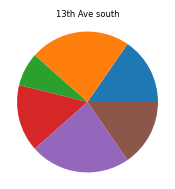
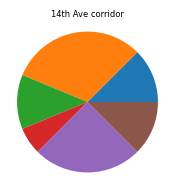
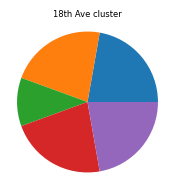
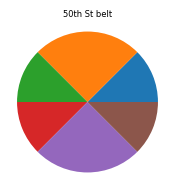
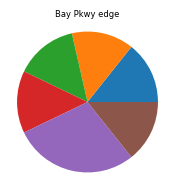
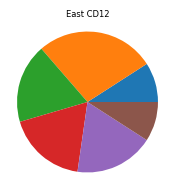
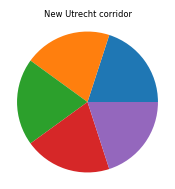
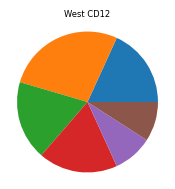

In [28]:
import folium
from folium.features import CustomIcon
from folium import FeatureGroup, LayerControl, CircleMarker, Popup, Tooltip
import os

# --- Map center ---
center_lat = np.mean([c[0] for c in zone_coords.values()])
center_lon = np.mean([c[1] for c in zone_coords.values()])

# Nicer basemap
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=14,
    tiles="cartodbpositron"
)

# Feature group so you can toggle this layer on/off
demand_layer = FeatureGroup(name="Projected school demand (5 yrs)").add_to(m)

# For proportional-circle scaling
if len(children_zone_network) > 0:
    max_classes_any_zone = children_zone_network["classes_needed"].max()
else:
    max_classes_any_zone = 1  # avoid division by zero

for zone, net_dict in zone_network_classes.items():
    total_classes = sum(net_dict.values())
    if total_classes == 0:
        continue

    # Fallback if zone is missing in zone_coords
    lat, lon = zone_coords.get(zone, (center_lat, center_lon))

    # --- Soft circle sized by total classes ---
    # radius between 10 and 30
    radius = 10 + 20 * (total_classes / max_classes_any_zone)

    CircleMarker(
        location=[lat, lon],
        radius=radius,
        color="#555555",
        weight=1,
        fill=True,
        fill_color="#ffcc99",
        fill_opacity=0.5,
    ).add_to(demand_layer)

    # --- Pie icon marker ---
    fname = "pie_" + zone.replace(" ", "_").replace("/", "_") + ".png"
    icon_path = os.path.join("zone_pies", fname)

    icon = CustomIcon(
        icon_image=icon_path,
        icon_size=(60, 60),
        icon_anchor=(30, 30),  # center the icon on the point
    )

    # --- Popup HTML (styled) ---
    rows_html = "".join(
        f"<tr><td>{net}</td>"
        f"<td style='text-align:right;'>{classes}</td></tr>"
        for net, classes in net_dict.items()
    )

    popup_html = f"""
    <div style="font-size:13px; line-height:1.4;">
        <h4 style="margin:0 0 4px 0; font-size:14px;">{zone}</h4>
        <p style="margin:0 0 6px 0;">
            <b>Total new classes (5 yrs):</b> {total_classes}
        </p>
        <table style="width:100%; border-collapse:collapse;">
            <thead>
                <tr>
                    <th style="text-align:left; padding:2px 0;">Network</th>
                    <th style="text-align:right; padding:2px 0;">Classes</th>
                </tr>
            </thead>
            <tbody>
                {rows_html}
            </tbody>
        </table>
        <p style="margin-top:6px; font-size:11px; color:#555;">
            Pie icon: share of classes by school network.
        </p>
    </div>
    """

    popup = Popup(popup_html, max_width=260)

    folium.Marker(
        location=[lat, lon],
        icon=icon,
        popup=popup,
        tooltip=Tooltip(f"{zone}: {total_classes} new classes"),
    ).add_to(demand_layer)

# Layer control (useful if you add more layers)
LayerControl(collapsed=False).add_to(m)

m
